<a href="https://colab.research.google.com/github/cosshoon/Anomaly-Detection-/blob/main/Previous_works/3D_printing_resolution_%EB%B6%84%EB%A5%98_Smart_Manufacturing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**텐서플로AI_중간평가 : CNN 모델 만들기**
* TPU 필라멘트의 3D 프린팅 결과물의 layer thickness 분류 및 flat type 분류

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/g')

Mounted at /g


In [ ]:
import os

path = '/g/My Drive/★텐서플로AI (강의관련)/중간과제'
os.listdir(path)

['이전파일들',
 'Printing_resolution.zip',
 'model1_saved.h5',
 'model2_saved.h5',
 '중간고사과제(printing resolution 분류)']

In [ ]:
!ls

sample_data


In [ ]:
!unzip -q '/g/My Drive/★텐서플로AI (강의관련)/중간과제/Printing_resolution.zip'

In [ ]:
!ls

dataset  sample_data


In [ ]:
!ls dataset

200  300  400  flat


* Training & Validation 데이터셋분류

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "dataset",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "dataset",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5200 files belonging to 4 classes.
Using 4160 files for training.
Found 5200 files belonging to 4 classes.
Using 1040 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['200', '300', '400', 'flat']


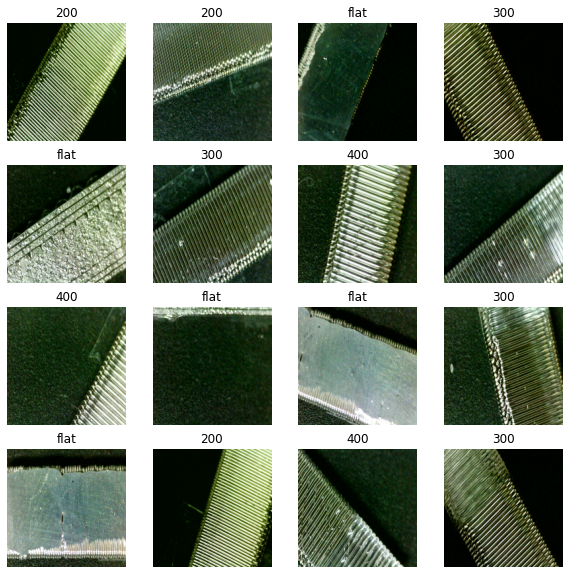

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for train_image_batch, train_labels_batch in train_ds:
  print(train_image_batch.shape)
  print(train_labels_batch.shape)
  break

for val_image_batch, val_labels_batch in val_ds:
  print(val_image_batch.shape)
  print(val_labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)


* 각각의 이미지 데이터 0~1사이의 숫자로 하기 위해 255로 나누어 rescaling

In [ ]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
train_normalized = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_image_batch, train_labels_batch = next(iter(train_normalized))
first_image = train_image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
val_normalized = val_ds.map(lambda x, y: (normalization_layer(x), y))
val_image_batch, val_labels_batch = next(iter(val_normalized))
first_image = val_image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
from tensorflow.keras import layers

num_classes = 4

model1 = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),

  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
model1.build((None, 180, 180, 3))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0

In [ ]:
model1.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc1 = ModelCheckpoint('/g/My Drive/★텐서플로AI (강의관련)/중간과제/model1_saved.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
mc2 = ModelCheckpoint('/g/My Drive/★텐서플로AI (강의관련)/중간과제/model2_saved.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
history1 = model1.fit(train_normalized, batch_size=batch_size, validation_data=val_normalized, epochs=30, callbacks=[es, mc1])

Epoch 1/30
130/130 [==============================] - 31s 118ms/step - loss: 1.2872 - accuracy: 0.3664 - val_loss: 0.9209 - val_accuracy: 0.6000

Epoch 00001: val_accuracy improved from -inf to 0.60000, saving model to /g/My Drive/★텐서플로AI (강의관련)/중간과제/model1_saved.h5
Epoch 2/30
130/130 [==============================] - 16s 118ms/step - loss: 0.6970 - accuracy: 0.7178 - val_loss: 0.3721 - val_accuracy: 0.8654

Epoch 00002: val_accuracy improved from 0.60000 to 0.86538, saving model to /g/My Drive/★텐서플로AI (강의관련)/중간과제/model1_saved.h5
Epoch 3/30
130/130 [==============================] - 16s 117ms/step - loss: 0.2210 - accuracy: 0.9217 - val_loss: 0.2582 - val_accuracy: 0.9144

Epoch 00003: val_accuracy improved from 0.86538 to 0.91442, saving model to /g/My Drive/★텐서플로AI (강의관련)/중간과제/model1_saved.h5
Epoch 4/30
130/130 [==============================] - 16s 117ms/step - loss: 0.1317 - accuracy: 0.9573 - val_loss: 0.1888 - val_accuracy: 0.9413

Epoch 00

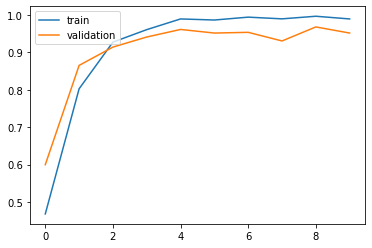

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
#하이퍼파라미터 튜닝을 통해 성능향상 시켜보기

!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 3.7MB/s 


In [ ]:
import kerastuner as kt

In [ ]:
from tensorflow.keras import layers, models

num_classes = 4

def model_builder(hp):
  #Dense Layer의 Output size를 바꾸기 위한 변수 선언
  hp_units_ = hp.Int('units', min_value = 128, max_value = 512, step = 128)

  #Adam Optimizer 학습률 선택지
  hp_learning_rate_ = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model2 = tf.keras.Sequential([
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),

    #Dense Layer에 넣기
    layers.Dense(units = hp_units_, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation = 'softmax')
  ])
  
  model2.build((None, 180, 180, 3))

  #Optimizer에 학습률 변수를 넣기 위해 keras.optimziers.Adam 사용
  model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate_),
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics = ['accuracy'])

  return model2

In [ ]:
# 인스턴스 만들기
tuner_ = kt.RandomSearch(model_builder,
                     objective = 'val_accuracy', 
                     max_trials = 20)

In [ ]:
tuner_.search(train_normalized, validation_data = val_normalized, epochs = 10)

Trial 9 Complete [00h 02m 44s]
val_accuracy: 0.949999988079071

Best val_accuracy So Far: 0.9788461327552795
Total elapsed time: 00h 24m 43s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner_.get_best_hyperparameters(num_trials = 1)[0]
best_hps.values

{'learning_rate': 0.001, 'units': 256}

In [ ]:
model2 = tuner_.hypermodel.build(best_hps)

In [ ]:
history2 = model2.fit(train_normalized, batch_size=batch_size, validation_data=val_normalized, epochs=30, callbacks=[es, mc2])

Epoch 1/30
130/130 [==============================] - 17s 122ms/step - loss: 1.1734 - accuracy: 0.4615 - val_loss: 0.5965 - val_accuracy: 0.7923

Epoch 00001: val_accuracy improved from -inf to 0.79231, saving model to /g/My Drive/★텐서플로AI (강의관련)/중간과제/model2_saved.h5
Epoch 2/30
130/130 [==============================] - 16s 120ms/step - loss: 0.5252 - accuracy: 0.8076 - val_loss: 0.3555 - val_accuracy: 0.8750

Epoch 00002: val_accuracy improved from 0.79231 to 0.87500, saving model to /g/My Drive/★텐서플로AI (강의관련)/중간과제/model2_saved.h5
Epoch 3/30
130/130 [==============================] - 16s 120ms/step - loss: 0.2920 - accuracy: 0.8984 - val_loss: 0.3438 - val_accuracy: 0.8663

Epoch 00003: val_accuracy did not improve from 0.87500
Epoch 4/30
130/130 [==============================] - 16s 118ms/step - loss: 0.1493 - accuracy: 0.9521 - val_loss: 0.2033 - val_accuracy: 0.9452

Epoch 00004: val_accuracy improved from 0.87500 to 0.94519, saving model to /g/My Drive/★ᄐ

# **>> 기존의 모델 1의 정확도 96.827% --> 개선된 모델 2의 정확도 97.500%로 상승**


아래는 모델 정보 및 history 그래프 작성한 것 들입니다.

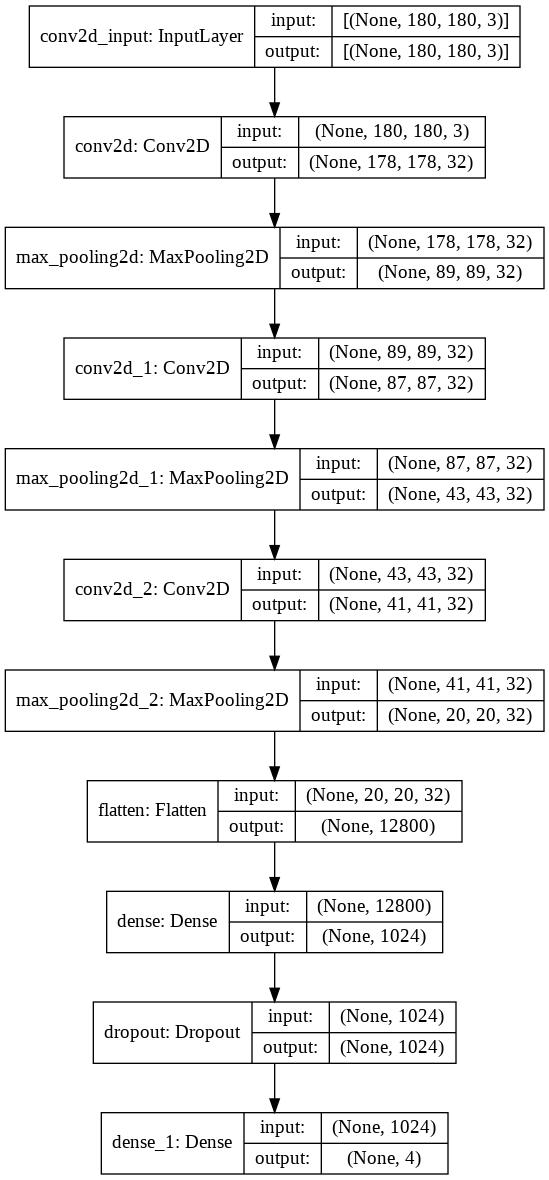

In [ ]:
keras.utils.plot_model(model1, show_shapes = True, show_layer_names = True)

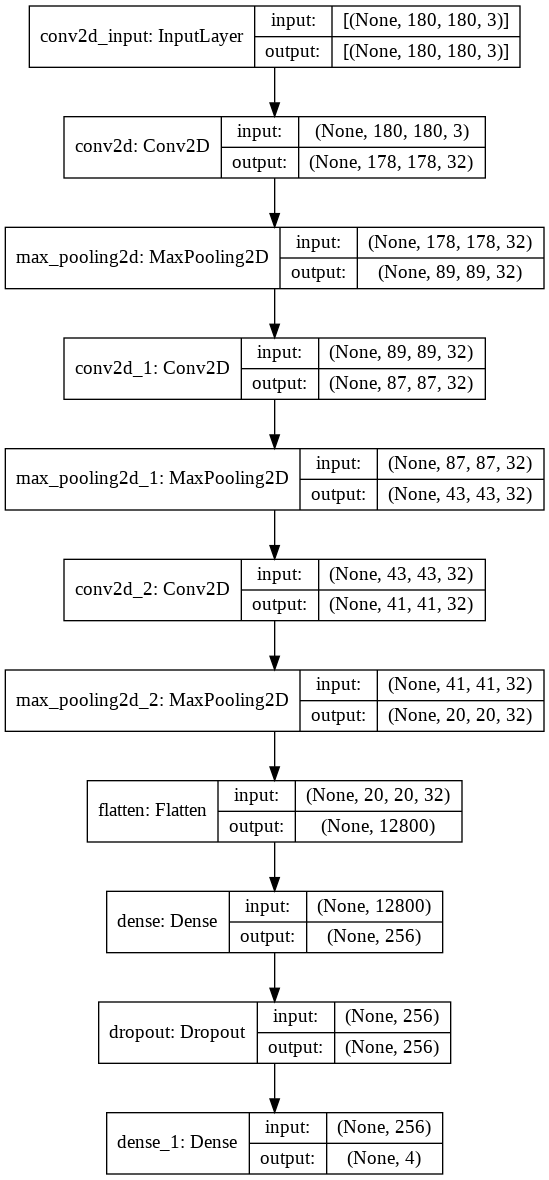

In [ ]:
keras.utils.plot_model(model2, show_shapes = True, show_layer_names = True)

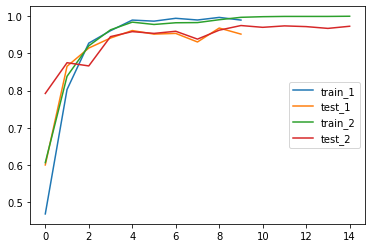

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.legend(['train_1', 'test_1','train_2', 'test_2'], loc='right')

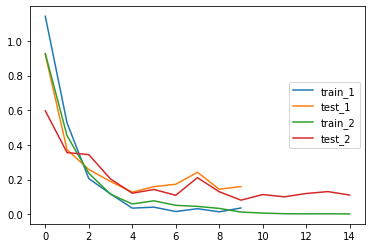

In [ ]:
plt.plot(history1.history['loss'], label = 'training loss')
plt.plot(history1.history['val_loss'], label = 'validation loss')

plt.plot(history2.history['loss'], label = 'training loss')
plt.plot(history2.history['val_loss'], label = 'validation loss')

plt.legend(['train_1', 'test_1','train_2', 'test_2'], loc='right')

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0